In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Edit options (optional)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

In [23]:
# == Functions ==

# - Plotting

def plot_correlation_heatmap(data: pd.DataFrame, columns: list):
    """
    Plot correlation heatmap of specific columns
    """
    correlation_matrix = data[columns].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidth=0.5)
    plt.title("Correlation Heatmap for selected attributes")
    plt.show()

def plot_distributions(data: pd.DataFrame):
    """
    Plot distributions of numeric data
    """
    sns.set_style("whitegrid", {"grid_linestyle": "--"})
    # For each column plot their distribution
    # I need a max column grid
    columns = data.columns
    num_plots = len(columns)
    num_rows = math.ceil(num_plots / 2)
    num_columns = 2

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 12))
    axes = axes.ravel()
    for i, column in enumerate(columns):
        sns.histplot(data[column], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)
        plt.xlim(0)

    if num_plots % 2 != 0:
        axes.flat[-1].set_visible(False)
   
    plt.tight_layout()
    plt.show()

def plot_violin(data: pd.DataFrame, column: str):
    """
    Plot violin 
    """    
    plt.figure(figsize=(6, 6))
    sns.violinplot(y=column, data=data, orient="v")
    plt.title(f"Violin Plot of {column}")
    
    plt.show()

# - PCA Analysis

def plot_PCA_variance(numbers: list, ratios: list):
    """
    Plot variance ratio
    """
    plt.grid(True)
    plt.plot(numbers, ratios, marker="o")
    plt.xlabel("n_components")
    plt.ylabel("Explained Variance Ratio")
    plt.title("n_components vs. Explained Variance Ratio")
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.show()

def plot_PCA_directions(data_numeric, numbers):
    data_scaled = StandardScaler().fit_transform(data_numeric)

    n_plots = len(numbers)
    n_cols = min(n_plots, 2)
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 6))
    fig.subplots_adjust(hspace=0.7)

    component_colors = plt.cm.viridis(np.linspace(0, 1, max(numbers) + 1))

    for i, number in enumerate(numbers):
        row = i // n_cols
        col = i % n_cols

        pca = PCA(n_components=number)
        pca.fit_transform(data_scaled)
        principal_direction = pca.components_

        ax = axes[row, col]
        ax.set_title(f"Principal Directions for {number} Components")
        for j, direction in enumerate(principal_direction):
            color = component_colors[j]
            ax.quiver(0, 0, direction[0], direction[1], angles='xy', scale_units='xy', scale=1.0, color=color, label=f"Component {j + 1}")
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")

    common_legend = fig.legend(handles=[plt.Line2D([0], [0], color=component_colors[i], label=f"Component {i + 1}") for i in range(max(numbers) + 1)], title="Components", loc='upper right', bbox_to_anchor=(1.2, 0.9))
    for handle in common_legend.legendHandles:
        handle.set_visible(True)

    for i in range(n_plots, n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

    plt.suptitle("Variance Explained by PCA Components", fontsize=16) 
    plt.tight_layout()
    plt.show()
    plt.show()


# ====

In [4]:
dataset_path = "dataset/dataset-spotify-2023.csv"
data = pd.read_csv(dataset_path, encoding="latin-1")

In [5]:

# Rename selected columns
columns = ["danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%",
"liveness_%", "speechiness_%"]
data = data.rename(columns={column: column.replace("_%", "") for column in columns})

In [6]:
# Print nan count of `key` (95), no other column has missing data
key_None_count = data["key"].isna().sum()
in_shazam_charts_None_count = data["in_shazam_charts"].isna().sum()

print("`key` None count: ", key_None_count)
print("`in_shazam_charts` None count: ", in_shazam_charts_None_count)

# Replace NaN values with Unspecified, it may be useful later on
data = data.replace(np.nan, "Unavailable")

`key` None count:  95
`in_shazam_charts` None count:  50


In [7]:

# Data is malformed, need to remove comma `,`
data["in_deezer_playlists"] = data["in_deezer_playlists"].replace(",", "", regex=True)
data["in_shazam_charts"] = data["in_deezer_playlists"].replace(",", "", regex=True)

# Convert columns to int64
# streams, in_deezer_playlists, in_shazam_charts
data["in_deezer_playlists"] = data["in_deezer_playlists"].astype(int)
data["in_shazam_charts"] = data["in_shazam_charts"].astype(int)

# Streams overflowed with int, so use np.int64 to fit the whole numbers
data["streams"] = data["streams"].astype(np.int64)

# Wee see that `streams` is very large compared to to other data, next larger is `in_spotify_playlists`
# Add extra column with log value of streams
data["streams_log"] = np.log2(data["streams"])

In [8]:
# Problematic record 576 removed manually
# Love Grows (Where My Rosemary Goes),Edison Lighthouse,1,1970,1,1,2877,0,,16,0,54,0,0,110,A,Major,53,75,69,7,0,17,3

# Print statistics, print them without the scientific notation
print("Statistics", data.describe().apply(lambda s: s.apply(lambda x: format(x, "g"))).transpose())

# Print unique values of mode
# print(data["mode"].value_counts())
# print("Index of mistake in data:", data.index[data["mode"] == "53"].tolist())

Statistics                      count         mean          std      min          25%   
artist_count           952      1.55672     0.893331        1            1  \
released_year          952      2018.29      11.0114     1930         2020   
released_month         952      6.03887      3.56457        1            3   
released_day           952      13.9443      9.19722        1            6   
in_spotify_playlists   952      5202.57       7901.4       31        874.5   
in_spotify_charts      952      12.0221      19.5824        0            0   
streams                952  5.14137e+08  5.66857e+08     2762  1.41636e+08   
in_apple_playlists     952      67.8666      86.4706        0           13   
in_apple_charts        952      51.9632      50.6289        0            7   
in_deezer_playlists    952      385.536      1131.08        0           13   
in_deezer_charts       952      2.66912      6.03815        0            0   
in_shazam_charts       952      385.536      1131.08 

In [9]:
# One-hot encoding values
# Do not add, trouble with PCAs
# data = pd.get_dummies(data, columns=["key", "mode"], prefix=["key", "mode"])

In [10]:
# Select numeric columns
data_numeric = data.select_dtypes(exclude="object")
data_numeric.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   artist_count          952 non-null    int64  
 1   released_year         952 non-null    int64  
 2   released_month        952 non-null    int64  
 3   released_day          952 non-null    int64  
 4   in_spotify_playlists  952 non-null    int64  
 5   in_spotify_charts     952 non-null    int64  
 6   streams               952 non-null    int64  
 7   in_apple_playlists    952 non-null    int64  
 8   in_apple_charts       952 non-null    int64  
 9   in_deezer_playlists   952 non-null    int32  
 10  in_deezer_charts      952 non-null    int64  
 11  in_shazam_charts      952 non-null    int32  
 12  bpm                   952 non-null    int64  
 13  danceability          952 non-null    int64  
 14  valence               952 non-null    int64  
 15  energy                9

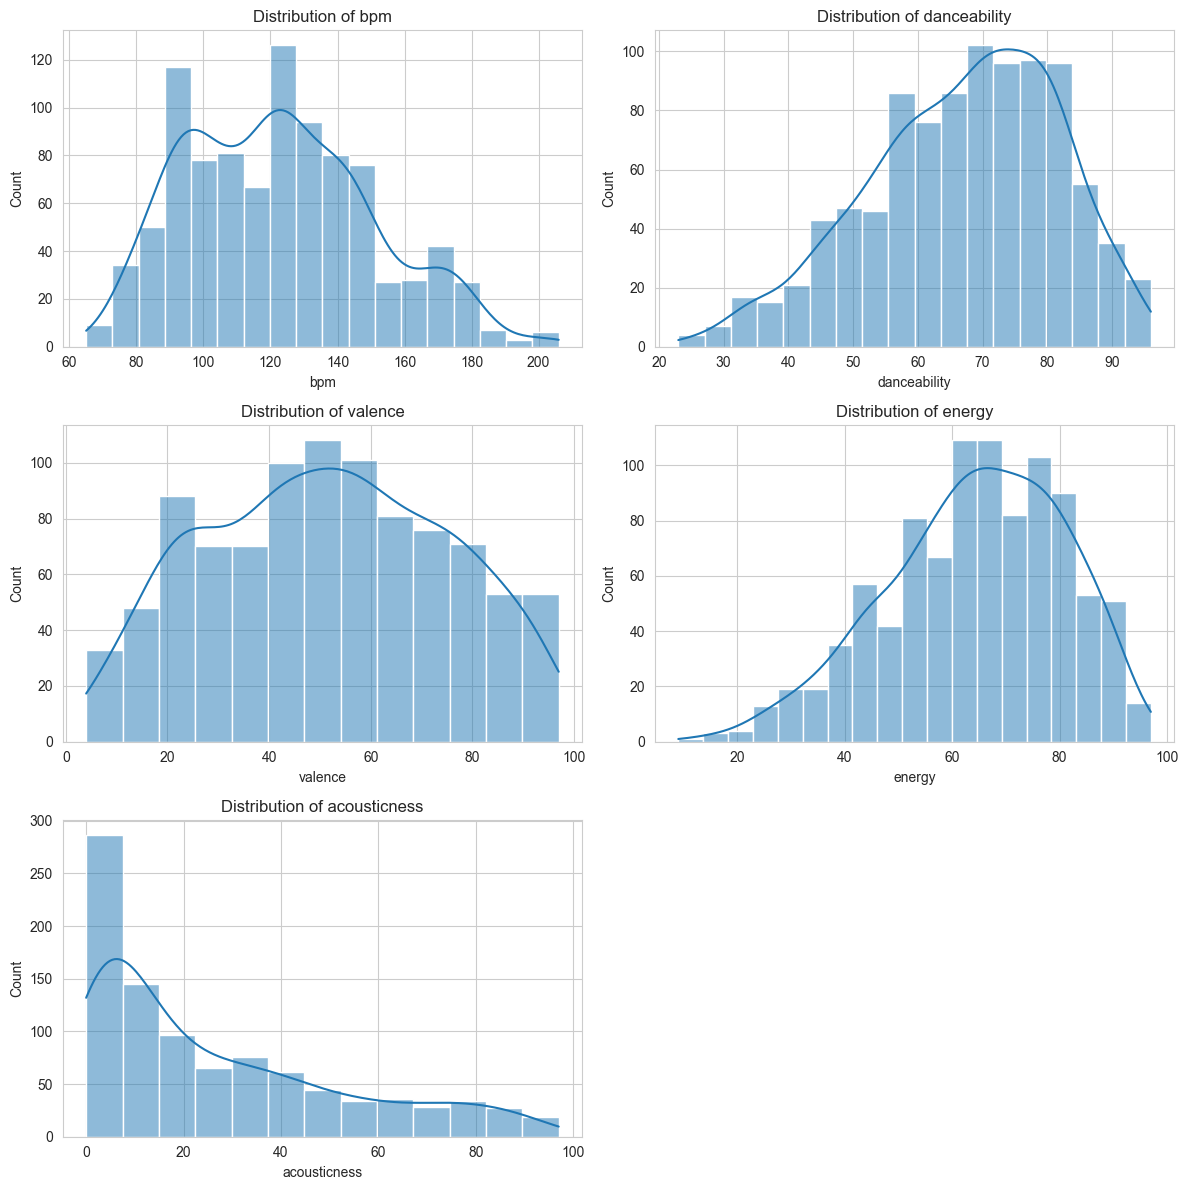

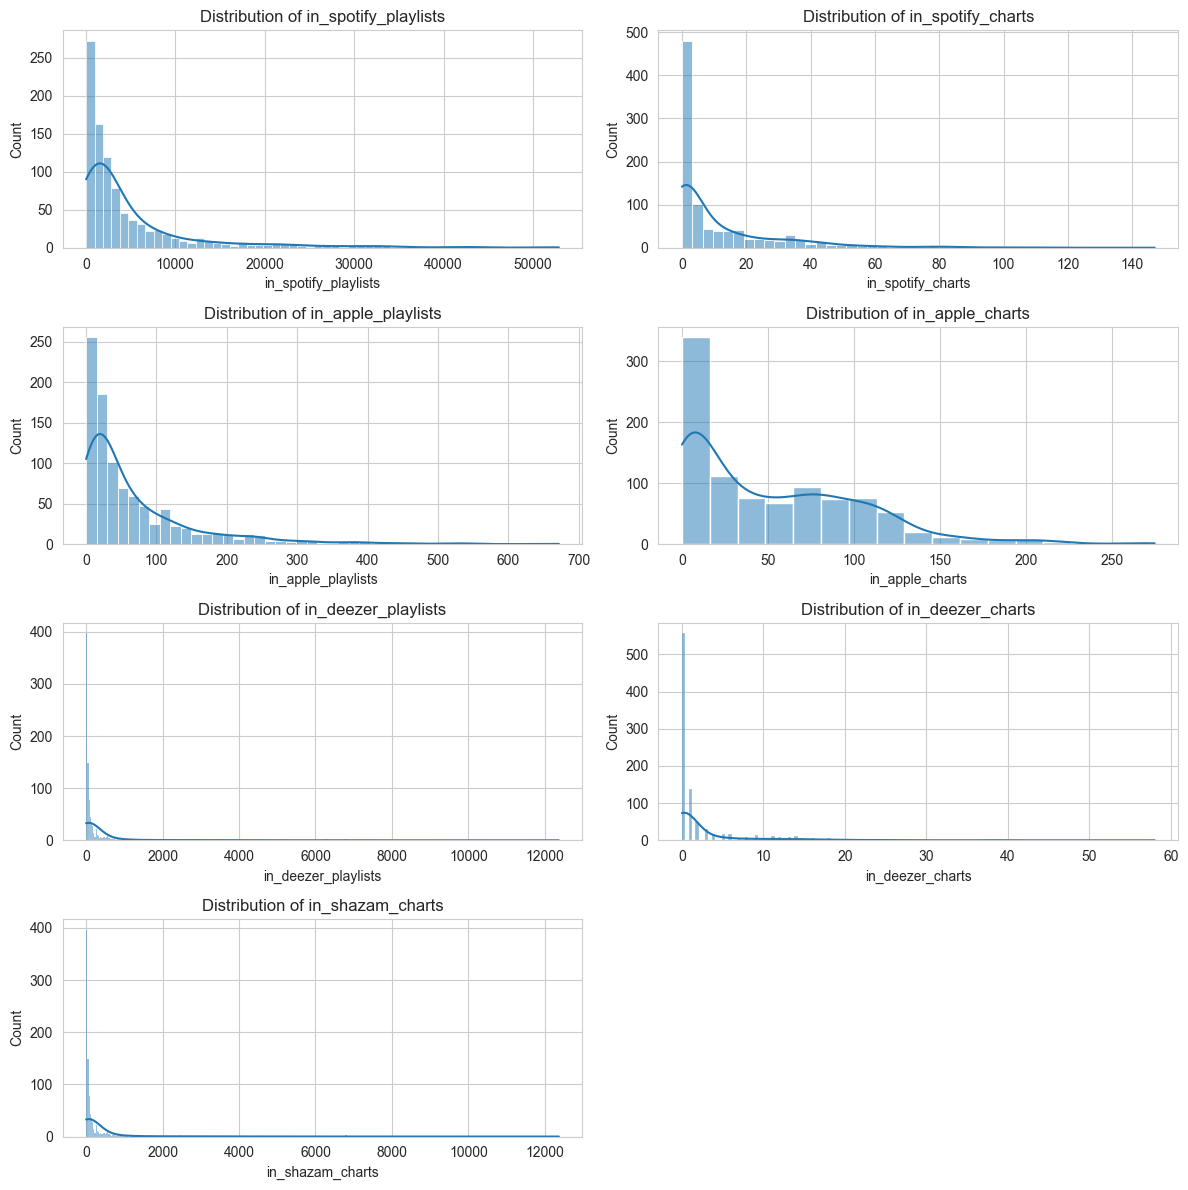

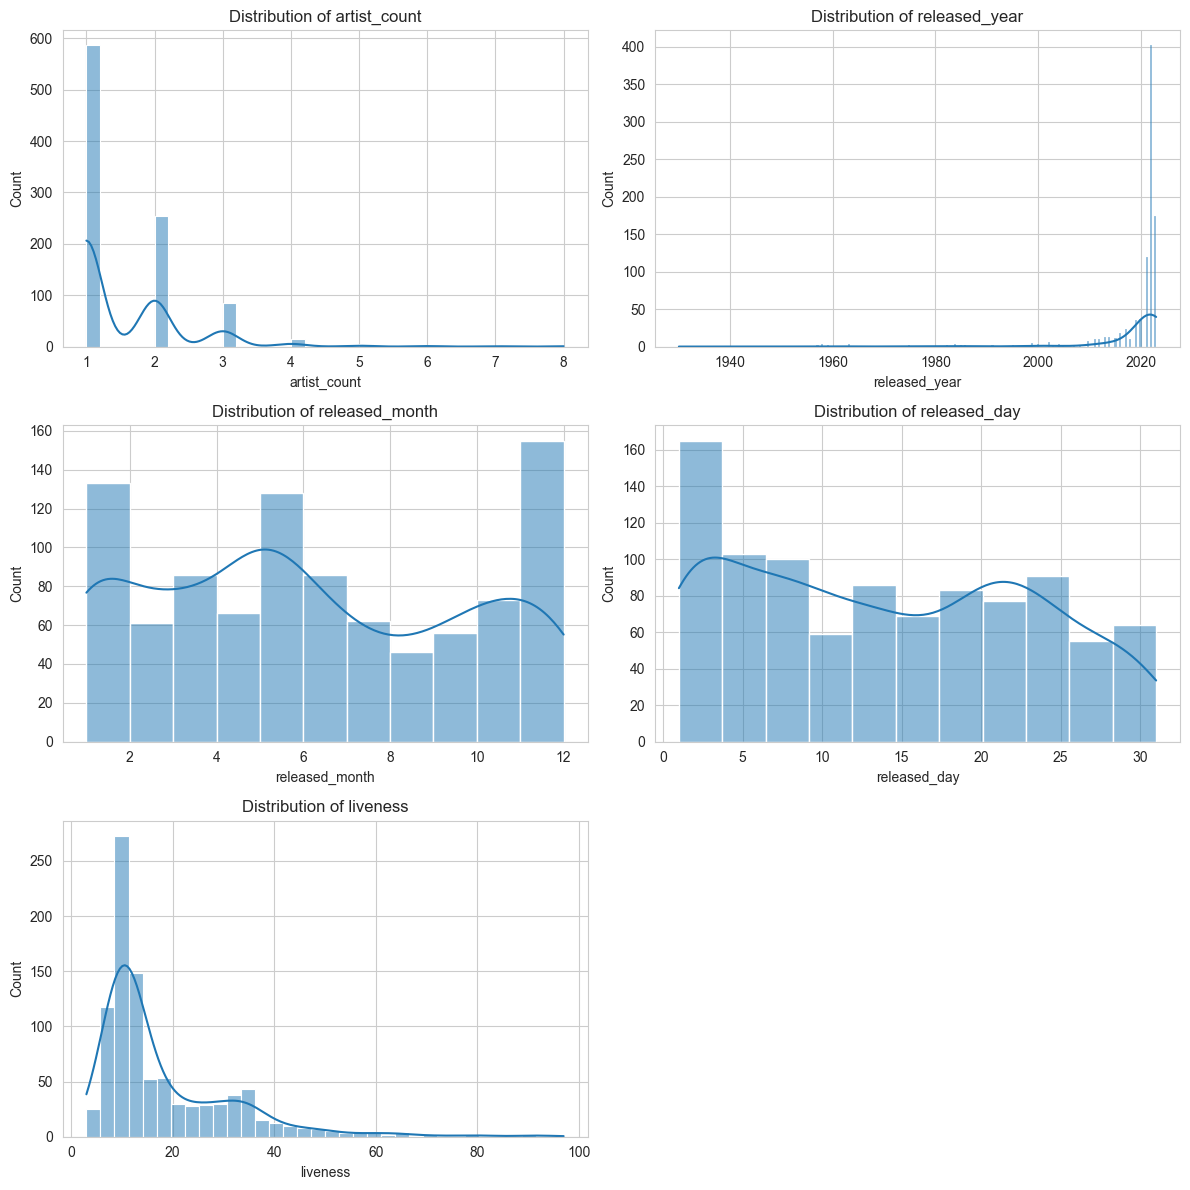

In [11]:
# Plot distribution of numeric datas
plot_distributions(data=data_numeric.iloc[:, 12:17])
plot_distributions(data=data_numeric.iloc[:, [4, 5, 7, 8, 9, 10, 11]])
plot_distributions(data=data_numeric.iloc[:, [0, 1, 2, 3, 18]])

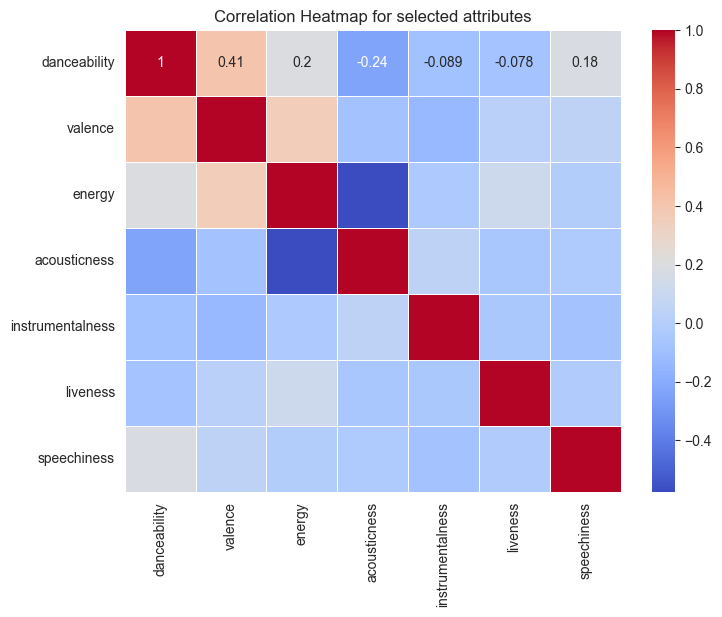

In [12]:
# Plot heatmap
plot_correlation_heatmap(data=data, columns = ["danceability", "valence", "energy", "acousticness", "instrumentalness",
"liveness", "speechiness"])

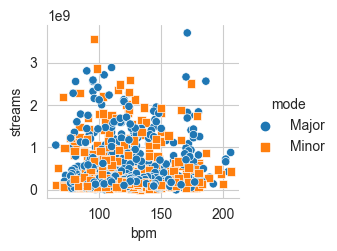

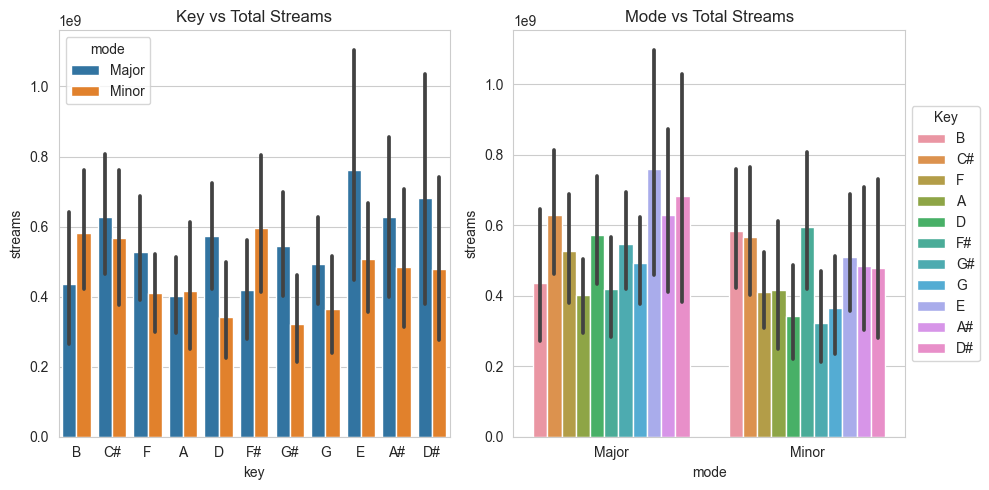

In [13]:
# Create a pair plot for BPM vs. Streams with hue based on Mode
sns.pairplot(data=data, x_vars=["bpm"], y_vars=["streams"], hue="mode", markers=["o", "s"])

# Create a bar chart for Key vs. Streams
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.barplot(data=data[data['key'] != 'Unavailable'], x="key", y="streams", hue="mode")
plt.title("Key vs Total Streams")

# Create a bar chart for Mode vs. Streams
plt.subplot(122)
sns.barplot(data=data[data['key'] != 'Unavailable'], x="mode", y="streams", hue="key")
plt.title("Mode vs Total Streams")
plt.legend(title="Key", loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Number of components	5	Total variance	0.5440279871332726
Number of components	10	Total variance	0.7804784639532846
Number of components	15	Total variance	0.9420255634260882
Number of components	20	Total variance	1.0


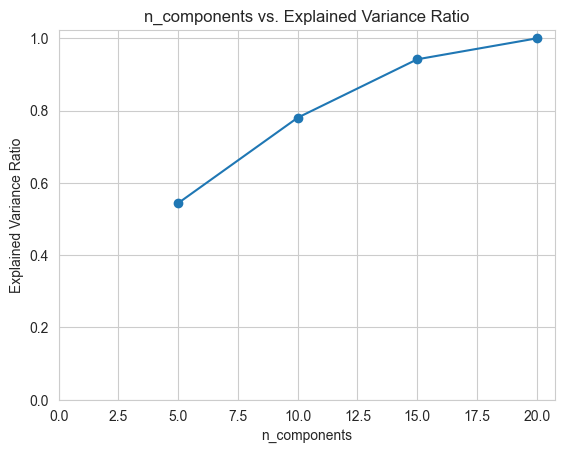

In [14]:
# PCA Analysis

# Number of PCA's and variance captured
data_scaled = StandardScaler().fit_transform(data_numeric)
variance_ratios = []
numbers = range(5, len(data_numeric.columns), 5)
for number in numbers:
    pca = PCA(n_components=number)
    pca.fit_transform(data_scaled)
    variance_ratios.append(np.sum(pca.explained_variance_ratio_))
    print(f"Number of components\t{number}\tTotal variance\t{sum(pca.explained_variance_ratio_)}")

plot_PCA_variance(numbers=numbers, ratios=variance_ratios)

C:\Users\mirto\AppData\Local\Temp\ipykernel_8152\2774698502.py:97: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in common_legend.legendHandles:


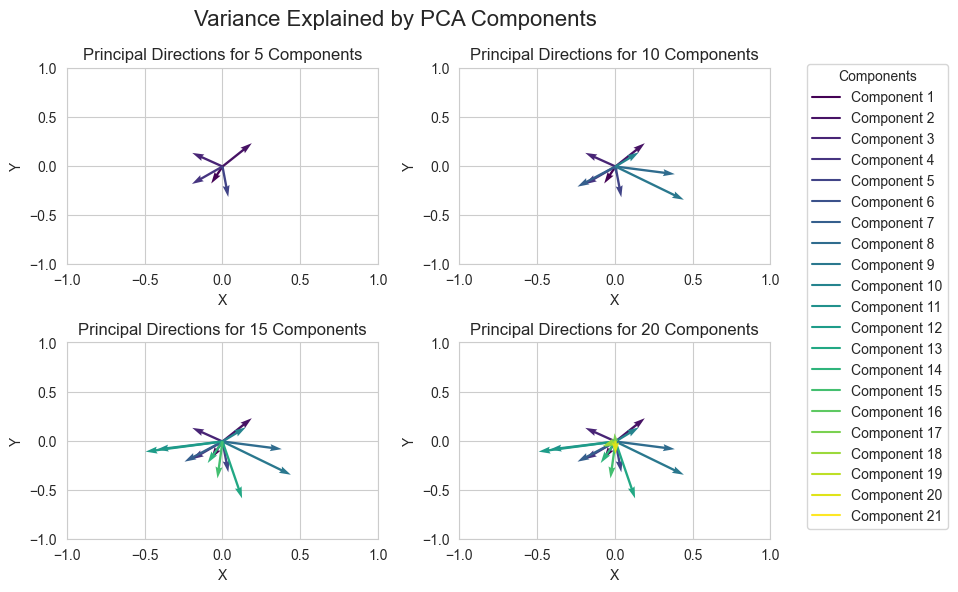

In [24]:
# PCA Directions
plot_PCA_directions(data_numeric=data_numeric, numbers=numbers)

In [22]:
# More on PCA Analysis

In [16]:
from scipy.stats import kstest
from scipy.stats import lognorm
from scipy.stats import shapiro

In [17]:

# Filter only the numeric columns
numeric_columns = data.select_dtypes(include=['number'])

alpha = 0.05  # Significance level

for column in numeric_columns.columns:
    data_column = numeric_columns[column]

    # Kolmogorov-Smirnov Test
    ks_statistic, ks_p_value = kstest(data_column, 'norm')
    
    # Shapiro-Wilk Test
    shapiro_statistic, shapiro_p_value = shapiro(data_column)
    
    # Log-Normality Test
    lognorm_params = lognorm.fit(data_column)
    lognorm_statistic, lognorm_p_value = kstest(data_column, 'lognorm', lognorm_params)
    
    print(f"Tests for column '{column}':")
    
    # Kolmogorov-Smirnov Test Results
    print(f"Kolmogorov-Smirnov Test:")
    print(f"KS Statistic: {ks_statistic}")
    print(f"P-Value: {ks_p_value}")
    if ks_p_value > alpha:
        print(f"The data in column '{column}' follows a normal distribution (fail to reject H0)")
    else:
        print(f"The data in column '{column}' does not follow a normal distribution (reject H0)")
    
    # Shapiro-Wilk Test Results
    print(f"\nShapiro-Wilk Test:")
    print(f"Test Statistic: {shapiro_statistic}")
    print(f"P-Value: {shapiro_p_value}")
    if shapiro_p_value > alpha:
        print(f"The data in column '{column}' follows a normal distribution (fail to reject H0)")
    else:
        print(f"The data in column '{column}' does not follow a normal distribution (reject H0)")
    
    # Log-Normality Test Results
    print(f"\nLog-Normality Test:")
    print(f"KS Statistic: {lognorm_statistic}")
    print(f"P-Value: {lognorm_p_value}")
    if lognorm_p_value > alpha:
        print(f"The data in column '{column}' follows a log-normal distribution")
    else:
        print(f"The data in column '{column}' does not follow a log-normal distribution")
    
    print("\n")

Tests for column 'artist_count':
Kolmogorov-Smirnov Test:
KS Statistic: 0.8413447460685429
P-Value: 0.0
The data in column 'artist_count' does not follow a normal distribution (reject H0)

Shapiro-Wilk Test:
Test Statistic: 0.6438103914260864
P-Value: 1.7067815295476272e-40
The data in column 'artist_count' does not follow a normal distribution (reject H0)

Log-Normality Test:
KS Statistic: 0.4008442119401423
P-Value: 1.4046654365756634e-138
The data in column 'artist_count' does not follow a log-normal distribution


Tests for column 'released_year':
Kolmogorov-Smirnov Test:
KS Statistic: 1.0
P-Value: 0.0
The data in column 'released_year' does not follow a normal distribution (reject H0)

Shapiro-Wilk Test:
Test Statistic: 0.4245677590370178
P-Value: 0.0
The data in column 'released_year' does not follow a normal distribution (reject H0)

Log-Normality Test:
KS Statistic: 0.33430332987435607
P-Value: 2.329690355533992e-95
The data in column 'released_year' does not follow a log-norma

C:\Users\mirto\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_continuous_distns.py:6120: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
c:\Users\mirto\miniconda3\envs\mlshit\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Tests for column 'in_apple_charts':
Kolmogorov-Smirnov Test:
KS Statistic: 0.8312414646904762
P-Value: 0.0
The data in column 'in_apple_charts' does not follow a normal distribution (reject H0)

Shapiro-Wilk Test:
Test Statistic: 0.8842672109603882
P-Value: 4.671673415615302e-26
The data in column 'in_apple_charts' does not follow a normal distribution (reject H0)

Log-Normality Test:
KS Statistic: 0.523655194579895
P-Value: 1.295764571317164e-243
The data in column 'in_apple_charts' does not follow a log-normal distribution


Tests for column 'in_deezer_playlists':
Kolmogorov-Smirnov Test:
KS Statistic: 0.9408769927246724
P-Value: 0.0
The data in column 'in_deezer_playlists' does not follow a normal distribution (reject H0)

Shapiro-Wilk Test:
Test Statistic: 0.3618941307067871
P-Value: 0.0
The data in column 'in_deezer_playlists' does not follow a normal distribution (reject H0)

Log-Normality Test:
KS Statistic: 0.5250617648526392
P-Value: 5.001810034379722e-245
The data in column '

In [18]:
# TODO: Handling outliers

## Characterizing data columns

* track_name    (discrete, nominal) 
* artist(s)_name    (discrete, nominal) 
* artist_count  (discrete, ratio) 
* released_year (discrete, ordinal) 
* released_month    (discrete, ordinal) 
* released_day  (discrete, ordinal) 
* in_spotify_playlists  (discrete, ratio) 
* in_spotify_charts (discrete, ratio) 
* streams   (discrete, ratio) 
* in_apple_playlists    (discrete, ratio)
* in_apple_charts   (discrete, ratio) 
* in_deezer_playlists   (discrete, ratio) 
* in_deezer_charts  (discrete, ratio)
* in_shazam_charts  (discrete, ratio) 
* bpm   (continuous, ratio) 
* key   (discrete, nominal) 
* mode  (discrete, nominal) 
* danceability_%    (continuous, ratio) 
* valence_% (continuous, ratio) 
* energy_%  (continuous, ratio) 
* acousticness_%    (continuous, ratio) 
* instrumentalness_%    (continuous, ratio) 
* liveness_%    (continuous, ratio) 
* speechiness_% (continuous, ratio) 

## Useful code from Toolbox

There is a list of already implemented functions we can use from the ToolBox to perform Data Analysis.

* categoric2numeric.py : one-hot encoding
* similarity.py : similarity matrices
* statistics.py : chi-squared tests and other
* ex1_5_4.py : regression problem plot
* ex2_1_2.py : scatterplot
* ex2_1_3.py : PCAs
* ...
